# Introduction

Using the development version of [scikit-learn](http://scikit-learn.org/dev/documentation.html), we construct a neural network (NN) regression model to map from a quantum mechanical potential to the energy levels (eigenvalues) for the single-particle system. The potential $V(x)$ is defined in the range $x\in [-1,1]$ and has the boundary conditions $V(\pm 1) = \infty$. The primary purpose of this notebook is to determine the optimal parameters of the NN. We do this using $10^4$ training examples. We train using these parameters. 

The potentials used for training and testing are generated in [potentials.ipynb](potentials.ipynb). The eigenvalues for all potentials are calculated in [eigenvalues.ipynb](eigenvalues.ipynb).

Documentation for `sklearn`'s supervised NN tools can be found here: http://scikit-learn.org/dev/modules/neural_networks_supervised.html. While already quite good, this documentation still appears to be "under construction".

# Preliminaries

In [24]:
%matplotlib inline
import numpy as np
from numpy.random import randint
import matplotlib.pyplot as plt
import pprint
from sklearn.model_selection import train_test_split
import pandas as pd

import sys
sys.path.append('/home/hudson/Development/Machine-Learns-Quantum/Utils')

In [25]:
# Number of basis states for the wavefunctions
NBW = 50
nbws = np.arange(1, NBW+1)
# Number of potentials:
NV = int(1E4)
# Number of basis states in the potential:
NB = 10
ns = np.arange(1, NB+1)
# Number of x coordinates:
Nx = 50
xs = np.linspace(-1,1,Nx)
# lambda (variance of Legendre coefficients):
lam = 0.75
# The variance of the n=0 legendre coefficient V_0:
V20 = 10

# Input file:
filepath = "../Data/eigenvalues_NV" + str(NV) \
    + "_NB" + str(NB) + "_lam" \
    + str(lam) + "_V20" + str(V20) + ".npy"
filepathSD = "../Data/eigenvaluesSD_NV" + str(NV) \
    + "_NB" + str(NB) + "_lam" \
    + str(lam) + "_V20" + str(V20) + ".npy"
data = np.load(filepath)
dataSD = np.load(filepathSD)
VSns = data[::,0:10]
VCns = data[::,10:20]
eigs = data[::,20::]

In [26]:
print("Data shape: ", data.shape, 
      "\nSine coefficients shape: ", VSns.shape,
      "\nCosine coefficients shape: ", VCns.shape, eigs.shape,
      "\nStd. dev. shape: ", dataSD.shape
     )

Data shape:  (10000, 60) 
Sine coefficients shape:  (10000, 10) 
Cosine coefficients shape:  (10000, 10) (10000, 40) 
Std. dev. shape:  (40,)


# Preprocessing

We know that the spectrum is symmetric under $x\to -x$. We can build this into our dataset. To do this, we duplicate the entire dataset but set all the Sine coefficients to their negative value. This is equivalent to taking $x\to-x$.

We extract the values of the potentials at a discreet, linear grid of $x$ points: $\left\{V(x) \,\, \mid \,\, x \in \{x_1,\,x_2,\ldots,x_{N_x}\}\right\}$. This grid of potential values will serve as the input to our NN model.

In [27]:
import preproc

In [28]:
numeigs = 10
Vgrid = preproc.potential_grid(ns, xs, VSns, VCns)
X = preproc.reflect_then_cat(Vgrid)
y = np.concatenate( (eigs, eigs) )[::,1:numeigs+1]

In [29]:
# Split test and train
test_frac = 0.3
random_state = 5
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_frac, random_state=random_state
)
print("X shape, y shape: ", X.shape, y.shape)
print("X_train shape, y_train shape: ", X_train.shape, y_train.shape)
print("X_test shape, y_test shape: ", X_test.shape, y_test.shape)

X shape, y shape:  (20000, 50) (20000, 10)
X_train shape, y_train shape:  (14000, 50) (14000, 10)
X_test shape, y_test shape:  (6000, 50) (6000, 10)


# Neural network

## Pipeline
We build a pipeline with 2 steps:

1. Scale the inputs.
2. Train the Neural network.

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline

In [31]:
# The Scaler
scale = StandardScaler(with_std=False)

# The NN regression model
hidden_layers = (100,)
regr =MLPRegressor(hidden_layer_sizes=hidden_layers,
                   activation = 'tanh',
                   algorithm = 'adam',
                   alpha = 0.1,
                   beta_1 = 0.85,
                   beta_2 = 0.9,
                   batch_size = 'auto',
                   max_iter = 500,
                   tol = 1e-6,
                   learning_rate_init = 0.001,
                   verbose = False
                 )

steps = [('scale', scale), ('regr', regr)]
model = Pipeline(steps)
#pprint.pprint(model.get_params())

## Model selection
We now use grid search to determine the optimum values of some import hyperparameters for the neural network model. For descriptions of the neural network parameters, the `scikit-learn` documentation for [`sklearn.neural_network.MLPRegressor`](http://scikit-learn.org/dev/modules/generated/sklearn.neural_network.MLPRegressor.html).

### Architecture tuning

#### A single hidden layer

In [32]:
from sklearn.model_selection import GridSearchCV
params_A1 = dict(
    regr__hidden_layer_sizes = [(30,),(40,),(50,),(60,),(70,),(80,),(90,),(100,)]
    )

model_gs_A1 = GridSearchCV(model, 
                        param_grid = params_A1,
                        verbose = 4,
                        n_jobs = 6
                       )
model_gs_A1.fit(X_train, y_train);

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] regr__hidden_layer_sizes=(30,) ..................................
[CV] regr__hidden_layer_sizes=(30,) ..................................
[CV] regr__hidden_layer_sizes=(30,) ..................................
[CV] regr__hidden_layer_sizes=(40,) ..................................
[CV] regr__hidden_layer_sizes=(40,) ..................................
[CV] regr__hidden_layer_sizes=(40,) ..................................
[CV] ......... regr__hidden_layer_sizes=(30,), score=0.957759 -  47.8s
[CV] regr__hidden_layer_sizes=(50,) ..................................
[CV] ......... regr__hidden_layer_sizes=(40,), score=0.968450 -  55.9s
[CV] regr__hidden_layer_sizes=(50,) ..................................
[CV] ......... regr__hidden_layer_sizes=(30,), score=0.955604 -  59.6s
[CV] regr__hidden_layer_sizes=(50,) ..................................
[CV] ......... regr__hidden_layer_sizes=(30,), score=0.961466 - 1.0min
[CV] regr__hidden

[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  3.3min


[CV] ......... regr__hidden_layer_sizes=(70,), score=0.983222 - 1.3min
[CV] regr__hidden_layer_sizes=(90,) ..................................
[CV] ......... regr__hidden_layer_sizes=(70,), score=0.980398 - 1.5min
[CV] regr__hidden_layer_sizes=(90,) ..................................
[CV] ......... regr__hidden_layer_sizes=(80,), score=0.983889 - 1.4min
[CV] regr__hidden_layer_sizes=(100,) .................................
[CV] ......... regr__hidden_layer_sizes=(80,), score=0.984412 - 1.5min
[CV] regr__hidden_layer_sizes=(100,) .................................
[CV] ......... regr__hidden_layer_sizes=(80,), score=0.986346 - 1.5min
[CV] regr__hidden_layer_sizes=(100,) .................................
[CV] ......... regr__hidden_layer_sizes=(90,), score=0.984662 - 1.4min
[CV] ......... regr__hidden_layer_sizes=(90,), score=0.986085 - 1.5min
[CV] ......... regr__hidden_layer_sizes=(90,), score=0.986095 - 1.6min
[CV] ........ regr__hidden_layer_sizes=(100,), score=0.985146 - 1.5min
[CV] .

[Parallel(n_jobs=6)]: Done  24 out of  24 | elapsed:  5.0min finished


In [33]:
print("Optimal_params: ", model_gs_A1.best_params_)
A1_df = pd.DataFrame(model_gs_A1.results_)

Optimal_params:  {'regr__hidden_layer_sizes': (90,)}


#### Two hidden layers

In [34]:
params_A2 = dict(
    regr__hidden_layer_sizes = [(30,30),(40,40),(50,50),(60,60),(70,70),(80,80),(90,90),(100,100)]
    )

model_gs_A2 = GridSearchCV(model, 
                        param_grid = params_A2,
                        verbose = 4,
                        n_jobs = 6
                       )
model_gs_A2.fit(X_train, y_train);

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] regr__hidden_layer_sizes=(30, 30) ...............................
[CV] regr__hidden_layer_sizes=(30, 30) ...............................
[CV] regr__hidden_layer_sizes=(30, 30) ...............................
[CV] regr__hidden_layer_sizes=(40, 40) ...............................
[CV] regr__hidden_layer_sizes=(40, 40) ...............................
[CV] regr__hidden_layer_sizes=(40, 40) ...............................
[CV] ...... regr__hidden_layer_sizes=(30, 30), score=0.969684 - 1.2min
[CV] regr__hidden_layer_sizes=(50, 50) ...............................
[CV] ...... regr__hidden_layer_sizes=(30, 30), score=0.969267 - 1.2min
[CV] regr__hidden_layer_sizes=(50, 50) ...............................
[CV] ...... regr__hidden_layer_sizes=(40, 40), score=0.975454 - 1.3min
[CV] regr__hidden_layer_sizes=(50, 50) ...............................
[CV] ...... regr__hidden_layer_sizes=(30, 30), score=0.967390 - 1.3min
[CV] regr__hidden

[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  4.5min


[CV] ...... regr__hidden_layer_sizes=(80, 80), score=0.983226 - 1.8min
[CV] regr__hidden_layer_sizes=(90, 90) ...............................
[CV] ...... regr__hidden_layer_sizes=(80, 80), score=0.982567 - 1.7min
[CV] regr__hidden_layer_sizes=(90, 90) ...............................
[CV] ...... regr__hidden_layer_sizes=(70, 70), score=0.983467 - 1.9min
[CV] regr__hidden_layer_sizes=(100, 100) .............................
[CV] ...... regr__hidden_layer_sizes=(70, 70), score=0.982298 - 2.1min
[CV] regr__hidden_layer_sizes=(100, 100) .............................
[CV] ...... regr__hidden_layer_sizes=(80, 80), score=0.982877 - 1.9min
[CV] regr__hidden_layer_sizes=(100, 100) .............................
[CV] ...... regr__hidden_layer_sizes=(90, 90), score=0.982967 - 1.9min
[CV] ...... regr__hidden_layer_sizes=(90, 90), score=0.983218 - 1.7min
[CV] .... regr__hidden_layer_sizes=(100, 100), score=0.984398 - 1.8min
[CV] ...... regr__hidden_layer_sizes=(90, 90), score=0.984938 - 1.9min
[CV] .

[Parallel(n_jobs=6)]: Done  24 out of  24 | elapsed:  6.9min finished


In [44]:
print("Optimal_params: ", model_gs_A2.best_params_)
A2_df = pd.DataFrame(model_gs_A2.results_)

Optimal_params:  {'regr__hidden_layer_sizes': (100, 100)}


#### Plot of architecture dependence

In [45]:
A2_df.columns

Index(['param_regr__hidden_layer_sizes', 'params', 'test_mean_score',
       'test_rank_score', 'test_split0_score', 'test_split1_score',
       'test_split2_score', 'test_std_score'],
      dtype='object')

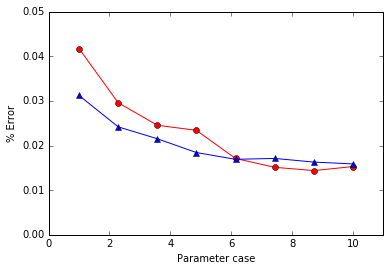

In [47]:
x = np.linspace(1,10, len(A1_df.test_mean_score))
plt.xlim = [0,11]
plt.plot(x, np.abs(1-A1_df.test_mean_score), color = 'r', marker = 'o', label="1 layer")
plt.plot(x, np.abs(1-A2_df.test_mean_score), color = 'b', marker = '^', label="2 layers")
plt.axis([0, 11, 0, 0.05])
plt.xlabel('Parameter case')
plt.ylabel('% Error')
plt.show()

We will use the 6th case of the single-layer NN. Beyond this point, you get diminishing returns, and it doesn't appear that the 2-layer network offers any improvement.

### Hyperparameter tuning

In [38]:
params_P = dict(
    regr__hidden_layer_sizes = [(50,50)],
    regr__alpha = [0.09, 0.1,0.11],
    regr__beta_1 = [0.75, 0.85],
    regr__beta_2 = [0.8,0.9]
    )

model_gs_P = GridSearchCV(model, 
                        param_grid = params_P,
                        verbose = 4,
                        n_jobs = 6
                       )
model_gs_P.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] regr__beta_2=0.8, regr__alpha=0.09, regr__beta_1=0.75, regr__hidden_layer_sizes=(50, 50) 
[CV] regr__beta_2=0.8, regr__alpha=0.09, regr__beta_1=0.75, regr__hidden_layer_sizes=(50, 50) 
[CV] regr__beta_2=0.8, regr__alpha=0.09, regr__beta_1=0.75, regr__hidden_layer_sizes=(50, 50) 
[CV] regr__beta_2=0.9, regr__alpha=0.09, regr__beta_1=0.75, regr__hidden_layer_sizes=(50, 50) 
[CV] regr__beta_2=0.9, regr__alpha=0.09, regr__beta_1=0.75, regr__hidden_layer_sizes=(50, 50) 
[CV] regr__beta_2=0.9, regr__alpha=0.09, regr__beta_1=0.75, regr__hidden_layer_sizes=(50, 50) 
[CV]  regr__beta_2=0.9, regr__alpha=0.09, regr__beta_1=0.75, regr__hidden_layer_sizes=(50, 50), score=0.977199 - 1.6min
[CV] regr__beta_2=0.8, regr__alpha=0.09, regr__beta_1=0.85, regr__hidden_layer_sizes=(50, 50) 
[CV]  regr__beta_2=0.8, regr__alpha=0.09, regr__beta_1=0.75, regr__hidden_layer_sizes=(50, 50), score=0.982118 - 1.6min
[CV] regr__beta_2=0.8, regr__alpha

[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  4.6min


[CV]  regr__beta_2=0.8, regr__alpha=0.1, regr__beta_1=0.75, regr__hidden_layer_sizes=(50, 50), score=0.979474 - 1.5min
[CV] regr__beta_2=0.8, regr__alpha=0.1, regr__beta_1=0.85, regr__hidden_layer_sizes=(50, 50) 
[CV]  regr__beta_2=0.9, regr__alpha=0.1, regr__beta_1=0.75, regr__hidden_layer_sizes=(50, 50), score=0.980145 - 1.4min
[CV] regr__beta_2=0.8, regr__alpha=0.1, regr__beta_1=0.85, regr__hidden_layer_sizes=(50, 50) 
[CV]  regr__beta_2=0.9, regr__alpha=0.1, regr__beta_1=0.75, regr__hidden_layer_sizes=(50, 50), score=0.976968 - 1.7min
[CV] regr__beta_2=0.9, regr__alpha=0.1, regr__beta_1=0.85, regr__hidden_layer_sizes=(50, 50) 
[CV]  regr__beta_2=0.8, regr__alpha=0.1, regr__beta_1=0.75, regr__hidden_layer_sizes=(50, 50), score=0.978647 - 1.8min
[CV] regr__beta_2=0.9, regr__alpha=0.1, regr__beta_1=0.85, regr__hidden_layer_sizes=(50, 50) 
[CV]  regr__beta_2=0.9, regr__alpha=0.1, regr__beta_1=0.75, regr__hidden_layer_sizes=(50, 50), score=0.976466 - 1.4min
[CV] regr__beta_2=0.9, regr__

[Parallel(n_jobs=6)]: Done  36 out of  36 | elapsed:  9.3min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=False)), ('regr', MLPRegressor(activation='tanh', algorithm='adam', alpha=0.1,
       batch_size='auto', beta_1=0.85, beta_2=0.9, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(100,), learning_rate='constant',
     ...,
       shuffle=True, tol=1e-06, validation_fraction=0.1, verbose=False,
       warm_start=False))]),
       fit_params={}, iid=True, n_jobs=6,
       param_grid={'regr__beta_2': [0.8, 0.9], 'regr__alpha': [0.09, 0.1, 0.11], 'regr__beta_1': [0.75, 0.85], 'regr__hidden_layer_sizes': [(50, 50)]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=4)

In [39]:
print("Best parameters:\n ", model_gs_P.best_params_)
print("Best score:\n", model_gs_P.best_score_)
model_best = model_gs_P.best_estimator_

Best parameters:
  {'regr__beta_2': 0.9, 'regr__alpha': 0.09, 'regr__beta_1': 0.85, 'regr__hidden_layer_sizes': (50, 50)}
Best score:
 0.980400397963


In [48]:
model_best.set_params(regr__verbose = True, regr__warm_start = True)
model_best.fit(X_train, y_train)

Iteration 247, loss = 0.00273839
Training loss did not improve more than tol=0.000001 for two consecutive epochs. Stopping.


Pipeline(steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=False)), ('regr', MLPRegressor(activation='tanh', algorithm='adam', alpha=0.09,
       batch_size='auto', beta_1=0.85, beta_2=0.9, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(50, 50),
       learning_rate='consta...tate=None, shuffle=True, tol=1e-06, validation_fraction=0.1,
       verbose=True, warm_start=True))])

In [49]:
# Save the network:
from sklearn.externals import joblib
filepath = "../Data/NN/NN" + str(NV) \
    + "_NB" + str(NB) + "_lam" \
    + str(lam) + "_V20" + str(V20) + ".pkl"
joblib.dump(model_best, filepath);

## Validation

We now test the NN on the test set. We measure the error for each eigenvalue relative to the width of the distribution of that eigenvalue over all of the generated potentials. Alternatively (and similarly) one could measure the error relative to the error incurred by simply guessing that the correct value equaled the uniform square-well value.

In [50]:
y_pred = model_best.predict(X_test)
y_scaled_err = np.sqrt(np.mean((y_pred - y_test)**2/dataSD[0:numeigs]**2, axis = 0))
print("Scaled RMS error by eigenvalue:\n", y_scaled_err)
print("Average of scaled RMS errors:\n ", np.mean(np.abs(y_scaled_err)))

Scaled RMS error by eigenvalue:
 [ 0.06818981  0.09077629  0.11798028  0.13206868  0.14906119  0.17305278
  0.24143632  0.22103638  0.24872646  0.1604767 ]
Average of scaled RMS errors:
  0.160280489574


# Visualizing the results

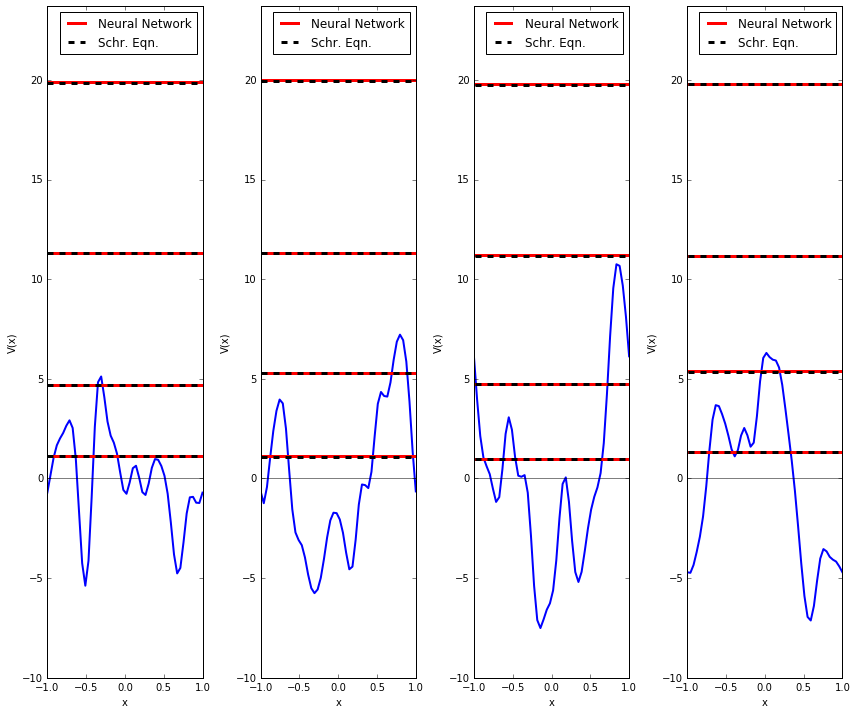

In [65]:
nrows = 1
ncols = 4
nplot = nrows * ncols
indplt = randint(0,X_test.shape[0], nplot)
numeigsplt = 4

def E0(n):
    return n**2 * np.pi**2 / 8.

plt.clf()
fig, axes = plt.subplots(nrows = nrows, ncols = ncols)
fig.set_size_inches(3*ncols,10*nrows)
subax = axes.flat

for i in range(0, len(indplt)):
        subax[i].plot(xs, X_test[indplt[i]], linewidth = 2, label='$V(x)$')
        subax[i].axhline(y=0,xmin=-1,xmax=1, linestyle='solid' ,color = 'k', lw=0.5)
        for j in range(0, numeigsplt):
            lastaxNN = subax[i].axhline(y=E0(j+1)+y_pred[indplt[i],j], xmin = -1, xmax = 1, 
                             ls = 'solid', color = 'r', lw = 3, label = 'Neural Network')
            lastaxSE = subax[i].axhline(y=E0(j+1)+y_test[indplt[i],j], xmin = -1, xmax = 1, 
                             ls = 'dashed', color = 'k', lw =3, label = 'Schr. Eqn.')

        subax[i].set_xlabel("x")
        subax[i].set_ylabel("V(x)")
        subax[i].set_ylim((-V20, 1.2*E0(numeigsplt)))
        subax[i].legend([lastaxNN, lastaxSE], ["Neural Network", "Schr. Eqn."])

plt.tight_layout();
plt.show();
plt.draw();
fig.savefig("../Plots/NNPred.png");